<a href="https://colab.research.google.com/github/niteesh555786/My-Notebook-Collection/blob/master/Problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!wget -O train.csv "https://www.dropbox.com/sh/ti9ta6mzdx56x1f/AAA-JbNaAHzMs_Xs3xwu7K53a/Training.csv?dl=0"

In [0]:
!wget -O test.csv "https://www.dropbox.com/sh/ti9ta6mzdx56x1f/AACZjJ4lHrh_RTDaCsQ5HeKia/Testing.csv?dl=0"

In [0]:
!wget -O sample.csv "https://www.dropbox.com/sh/ti9ta6mzdx56x1f/AACGdX2acMpsNpia_7FN_2c9a/Sample%20Submission.csv?dl=0"

In [5]:
!ls

sample.csv  sample_data  test.csv  train.csv


#DataSet v1 Analysis

In [0]:
df=pd.read_csv('train.csv')

In [13]:
df.head()

,Cycle,Type,EndTime,Time,Values
0,2,2,3490.0,101.0,20.402
1,2,2,3490.0,102.0,20.402
2,2,2,3490.0,103.0,20.402
3,2,2,3490.0,104.0,20.402
4,2,2,3490.0,105.0,20.402


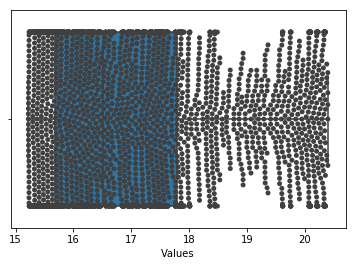

In [48]:
sns.boxplot("Values", data=df[df['Cycle']==2])
sns.swarmplot("Values", data=df[df['Cycle']==2], color=".25")

(**To-Do**)
*We can clip off the training data set till 1800. as req in test data*

In [0]:
def makeFeatureDataset(df):
  cycle_set=df['Cycle'].unique()
  
  data=[]
  for i in range(len(cycle_set)):
    val=[]
    df_temp=df[df['Cycle']==cycle_set[i]]
    #val.append(cycle_set[i])
    val.append(float('%.3f'%(df_temp['Values'].mean())))
    val.append(float('%.3f'%(df_temp['Values'].var())))
    val.append(float('%.3f'%(df_temp['Values'].std())))
    val.append(float('%.3f'%(df_temp['Values'].quantile(0.25))))
    val.append(float('%.3f'%(df_temp['Values'].quantile(0.75))))
    val.append(df_temp.iloc[0]['EndTime'])

    data.append(val)
    
  col=['Mean', 'Variance', 'Std-Dev', '25-Quartile', '75-Quartile', 'EndTime']
  df_feature = pd.DataFrame(data, columns = col)
    
  return df_feature

In [0]:
df_feature= makeFeatureDataset(df)

In [51]:
df_feature.head()

,Mean,Variance,Std-Dev,25-Quartile,75-Quartile,EndTime
0,16.970,2.257,1.502,15.677,17.795,3490.0
1,18.490,1.851,1.360,17.133,19.910,2556.0
2,15.356,8.570,2.928,12.124,18.067,3909.0
3,18.716,2.402,1.550,16.947,20.182,2113.0
4,16.926,5.426,2.329,14.253,19.002,2978.0


In [45]:
len(df_feature)

40

#Analysis of Each Feature with #EndTime

## 1.Finding PairWise RelationShip

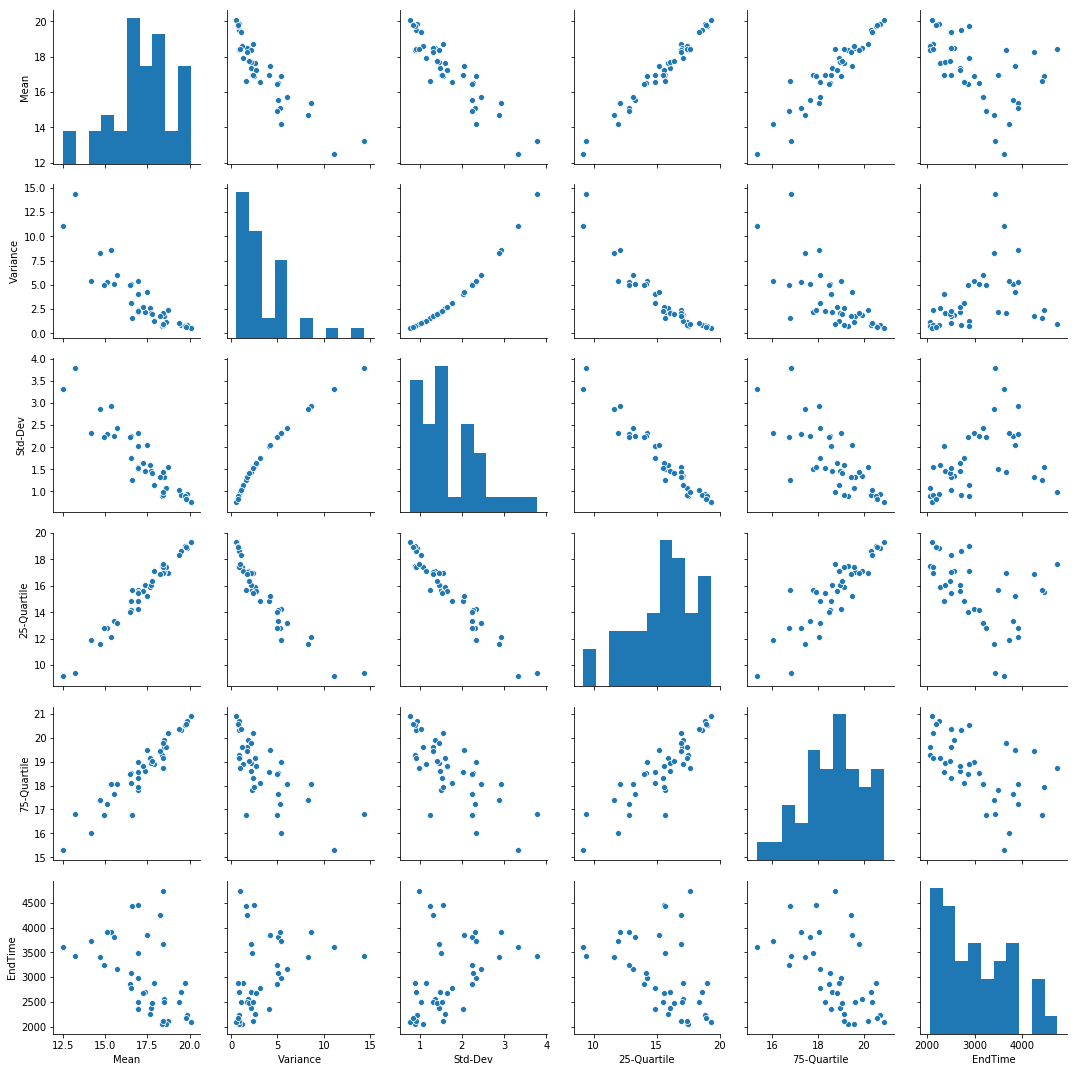

In [53]:
sns.pairplot(df_feature);

## 2. Generating a Correlation Matrix between features

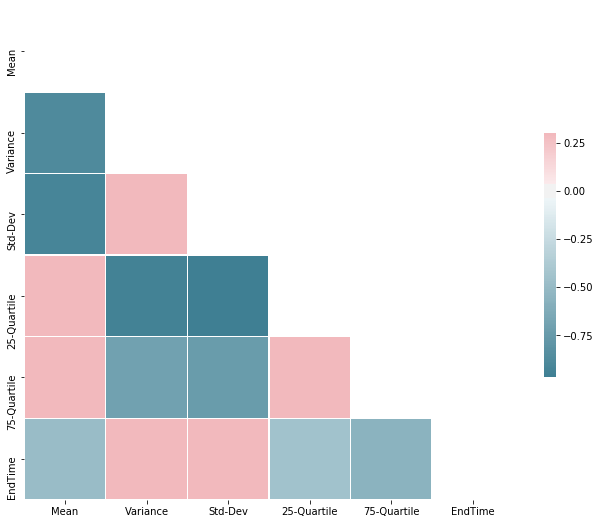

In [9]:
# Compute the correlation matrix
corr = df_feature.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

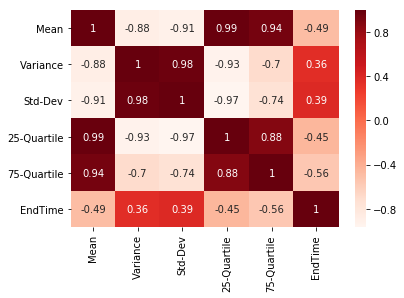

In [10]:
#Using Pearson Correlation
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)

# Feature Selection

## 1. Filter Method

We feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

We will first run one iteration here just to get an idea of the concept and then we will run the same code in a loop, which will give the final set of features. Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.

In [11]:
#Correlation with output variable
cor_target = abs(corr["EndTime"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

Mean           0.486528
25-Quartile    0.445167
75-Quartile    0.559713
EndTime        1.000000
Name: EndTime, dtype: float64

In [12]:
#Checking Internal Feature Correlation
print(df_feature[["25-Quartile","75-Quartile"]].corr())
print(df_feature[["25-Quartile","Mean"]].corr())

             25-Quartile  75-Quartile
25-Quartile     1.000000     0.877172
75-Quartile     0.877172     1.000000
             25-Quartile      Mean
25-Quartile     1.000000  0.985775
Mean            0.985775  1.000000


1. *25- Quartile and Mean are strictly related. Need to drop one before predicting.*
2. *We can combine 25Quartile and 75Quartile into one feature i.e. (75Q-25Q) that will be interQuartile Range.*

## 2. Wrapper Method

A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. We will discuss Backward Elimination and RFE here.

### i. Backward Elimination

We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

We will first run one iteration here just to get an idea of the concept and then we will run the same code in a loop, which will give the final set of features. Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.

In [0]:
X=df_feature[['Mean','Variance','Std-Dev','25-Quartile','75-Quartile']]
Y=df_feature[['EndTime']]

In [0]:
#install if sm throws error
#!pip install statsmodels==0.10.0rc2 --pre

In [14]:
import statsmodels.api as sm

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(Y,X_1).fit()
model.pvalues

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const          0.334244
Mean           0.931385
Variance       0.272889
Std-Dev        0.003623
25-Quartile    0.055598
75-Quartile    0.005137
dtype: float64

In [16]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['Std-Dev', '25-Quartile', '75-Quartile']


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


###ii. Recursive Feature Elimination

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 3)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)
print(X.columns)

[False False  True  True  True]
[3 2 1 1 1]
Index(['Mean', 'Variance', 'Std-Dev', '25-Quartile', '75-Quartile'], dtype='object')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
from sklearn.model_selection import train_test_split

#no of features
nof_list=np.arange(1,5)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 3
Score with 3 features: 0.740102


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [38]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 3)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)


Index(['Std-Dev', '25-Quartile', '75-Quartile'], dtype='object')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### iii. Embedded Method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [0]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Text(0.5, 1.0, 'Feature importance using Lasso Model')

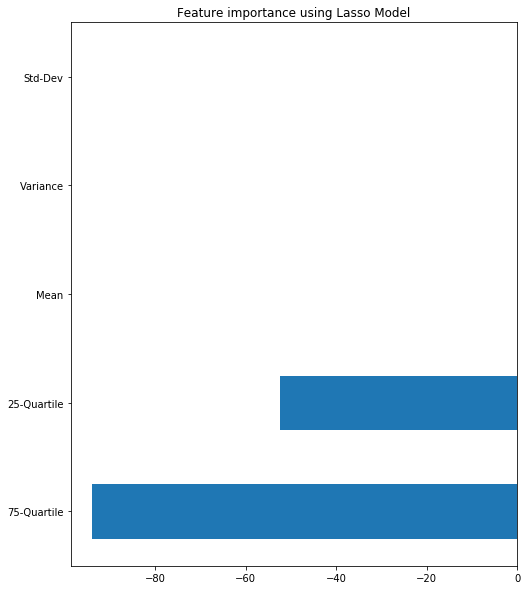

In [44]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

# Modeling

In [45]:
df_feature.head()

,Mean,Variance,Std-Dev,25-Quartile,75-Quartile,EndTime
0,16.970,2.257,1.502,15.677,17.795,3490.0
1,18.490,1.851,1.360,17.133,19.910,2556.0
2,15.356,8.570,2.928,12.124,18.067,3909.0
3,18.716,2.402,1.550,16.947,20.182,2113.0
4,16.926,5.426,2.329,14.253,19.002,2978.0


In [52]:
df_feature.dtypes

Mean           float64
Variance       float64
Std-Dev        float64
25-Quartile    float64
75-Quartile    float64
EndTime        float64
dtype: object

In [47]:
X.head()

,Mean,Variance,Std-Dev,25-Quartile,75-Quartile
0,16.970,2.257,1.502,15.677,17.795
1,18.490,1.851,1.360,17.133,19.910
2,15.356,8.570,2.928,12.124,18.067
3,18.716,2.402,1.550,16.947,20.182
4,16.926,5.426,2.329,14.253,19.002


In [48]:
Y.head()

,EndTime
0,3490.0
1,2556.0
2,3909.0
3,2113.0
4,2978.0


In [0]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## Trying Various Models

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection, tree, linear_model
from sklearn.metrics import mean_absolute_error
import xgboost

### 1. Linear regression

In [55]:
linear_regr = linear_model.LinearRegression()
linear_regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
linear_regr.score(X_test,y_test)

0.7617582149882273

In [66]:
predictions = linear_regr.predict(X_test)
print(mean_absolute_error(y_test,predictions))

342.8787569759661


### 2. XGBoost

In [0]:
# Let's try XGboost algorithm to see if we can get better results
xgb_regr = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [58]:
xgb_regr.fit(X_train,y_train)

[06:24:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [62]:
predictions = xgb_regr.predict(X_test)
print(mean_absolute_error(y_test,predictions))

624.7912902832031


In [63]:
predictions

array([2861.5535, 2866.9543, 2834.911 , 2695.2622, 3045.5693, 3728.7083,
       2834.911 , 2473.5088], dtype=float32)

In [65]:
y_test

,EndTime
22,3664.0
20,2246.0
25,2092.0
4,2978.0
10,2058.0
15,4428.0
28,2184.0
11,2262.0


# Predicting

In [0]:
df_test=pd.read_csv('test.csv')

In [68]:
df_test.head()

,Cycle,Type,Time,Values
0,100,2,101,20.456
1,100,2,102,20.456
2,100,2,103,20.456
3,100,2,104,20.448
4,100,2,105,20.448


In [0]:
def makeTestFeatureDataset(df):
  cycle_set=df['Cycle'].unique()
  
  data=[]
  for i in range(len(cycle_set)):
    val=[]
    df_temp=df[df['Cycle']==cycle_set[i]]
    val.append(cycle_set[i])
    val.append(float('%.3f'%(df_temp['Values'].mean())))
    val.append(float('%.3f'%(df_temp['Values'].var())))
    val.append(float('%.3f'%(df_temp['Values'].std())))
    val.append(float('%.3f'%(df_temp['Values'].quantile(0.25))))
    val.append(float('%.3f'%(df_temp['Values'].quantile(0.75))))

    data.append(val)
    
  col=['Cycle','Mean', 'Variance', 'Std-Dev', '25-Quartile', '75-Quartile']
  df_feature = pd.DataFrame(data, columns = col)
    
  return df_feature

In [0]:
df_test_feature= makeTestFeatureDataset(df_test)

In [80]:
df_test_feature.head()

,Cycle,Mean,Variance,Std-Dev,25-Quartile,75-Quartile
0,100,18.764,0.762,0.873,18.235,19.327
1,200,18.082,2.620,1.619,16.772,19.623
2,300,18.767,1.034,1.017,17.827,19.846
3,2200,18.439,1.301,1.141,17.363,19.346
4,2300,17.558,2.229,1.493,16.096,18.379


In [0]:
X_test=df_test_feature.drop(columns='Cycle')

In [83]:
X_test.head()

,Mean,Variance,Std-Dev,25-Quartile,75-Quartile
0,18.764,0.762,0.873,18.235,19.327
1,18.082,2.620,1.619,16.772,19.623
2,18.767,1.034,1.017,17.827,19.846
3,18.439,1.301,1.141,17.363,19.346
4,17.558,2.229,1.493,16.096,18.379


In [0]:
y_pred=linear_regr.predict(X_test)

In [0]:
df_result = pd.DataFrame(columns = ['Cycle','EndTime'])

In [0]:
df_result['Cycle']=df_test_feature['Cycle']
df_result['EndTime']=y_pred

In [104]:
df_result.head()

,Cycle,EndTime
0,100,3222.143815
1,200,3428.268979
2,300,2389.699799
3,2200,2935.454826
4,2300,3801.960164


# Saving File

In [0]:
#Saving the file
df_result.to_csv('resultv1.0.csv',index=False) 

In [114]:
from google.colab import files
files.download('resultv1.0.csv')

MessageError: ignored